In [2]:
import numpy as np
np.random.seed(0)
num_samples=200
seq_length=4
vocab_size=20

X_data=np.random.randint(0, vocab_size-1, size=(num_samples, seq_length))
Y_data=X_data+1


In [3]:
def one_hot(x,vocab_size):
  return np.eye(vocab_size)[x]

X_oh=one_hot(X_data, vocab_size)
Y_oh=one_hot(Y_data, vocab_size)

#shape changes from X_data = (200,4) -> (200,4,20)
#implying - 200 samples, 4 time steps and 20 dimensional token space

In [4]:
#now each token is 20 dimensional sparse vector
# for eg 3 is [0 0 0 3 0 0 ..]
#so we introduce learnable embedding matrix

d_model=32
W_embed=np.random.randn(vocab_size, d_model)*0.01

#each row is one token's semantic vector
#these vectors will be learnt during training
#size is (vocab_size, d_model) = (20,32)

In [5]:
#building embedded input sequences
X_emb=X_oh@W_embed
# (200,4,20) @ (20, 32) -> (200, 4, 32)

In [6]:
#positional encoding
positions = np.arange(seq_length)[:, None]
dimensions = np.arange(d_model)[None, :]
PE= np.sin(positions / (10000**(dimensions/ d_model)))

#size PE -> (4,32)

In [7]:
#adding positional information to embeddings
X_input=X_emb+PE
#here we are combining two sources of information
#      - token identity ( from embedding matrix -what is this token)
#      - token position ( where is this token in the sequence )

In [8]:
#Query, Key, Value Projection Matrices
W_q=np.random.randn(d_model, d_model)* 0.01
W_k=np.random.randn(d_model, d_model)* 0.01
W_v=np.random.randn(d_model, d_model)* 0.01
#each token embedding will be projected into three different semantic spaces:
#Query - what is token looking for
#key - what this token offers
#value - what information this token contains

In [9]:
#computing Q,K,V for the dataset
Q= X_input@ W_q
K= X_input@ W_k
V= X_input@ W_v

In [10]:
d_k= d_model
scores = Q@K.transpose(0,2,1)/ np.sqrt(d_k)

#outputs how much each token cares about every other token
#shapes Q-> (200, 4, 32)
# K(T) -> (200, 32, 4)
# scores -> (200, 4, 4)
#scores [i, j] = similarity (query at position i, key at position j)

In [11]:
#softmax->attention weights
def softmax(x):
  exp_x= np.exp(x- np.max(x, axis=-1, keepdims=True))
  return exp_x/ np.sum(exp_x, axis=-1, keepdims=True)

attention_weights=softmax(scores)
#attention_weights [i] = how much token i distributes its attention accross all tokens

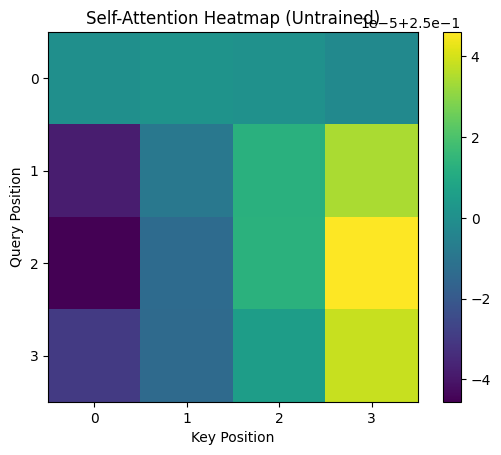

In [12]:
import matplotlib.pyplot as plt

sample_id = 0
plt.imshow(attention_weights[sample_id], cmap="viridis")
plt.colorbar()
plt.xticks(range(seq_length))
plt.yticks(range(seq_length))
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.title("Self-Attention Heatmap (Untrained)")
plt.show()

#each cell(i, j) answers : how much does token i attend to token j
#darker= more attention
#lighter = less attention


In [13]:
#right now no strong diagonal etc
#but after training

In [14]:
Z= attention_weights @V
#applying attention weights to values
# (200,4,4) @ (200,4,32) -> (200, 4 , 32)
#Z is the output of self attention mechanism


In [16]:
#Transformers re-mix attention outpyt using another linear layer
W_o= np.random.randn(d_model, d_model)*0.01
attention_output= Z@W_o
#(200,4,32)@(32,32)-> (200, 4,32)

In [17]:
from enum import KEEP
#Residual connection and layer normalization
#Transformers never trust raw outputs they add original input back ( called residual ) and normalize

def layer_norm(x, eps= 1e-6):
  mean= x.mean(axis=-1, keepdims=True)
  std= x.std(axis=-1, keepdims=True)
  return (x-mean)/ (std+eps)
  return (x-mean)/ std+ eps

In [20]:
x1= layer_norm(X_input + attention_output)
#residual connection + normalization
#it prevents exploding and vanishing activations
#enables deep stacking of transformer blocks

In [21]:
#position - wise feed forward network
#each token now goes through a mini nueral network independently
d_ff= 64 # dimension of feed forward network
W1= np.random.randn(d_model, d_ff)* 0.01
b1= np.zeros( d_ff)
W2= np.random.randn(d_ff, d_model)* 0.01
b2= np.zeros(d_model)

# reulu activation
def relu (x):
  return np.maximum(0,x)


In [24]:
#forward pass
ffn_hidden = relu(x1 @ W1 + b1)
ffn_output=ffn_hidden @ W2 + b2


In [25]:
# second add and norm
x2 = layer_norm (x1+ ffn_output)

In [27]:
W_vocab = np.random.randn(d_model, vocab_size) * 0.01
b_vocab = np.zeros(vocab_size)

logits = x2 @ W_vocab + b_vocab

In [28]:
predictions = softmax(logits)


In [29]:
predictions

array([[[0.05284035, 0.04969   , 0.04617561, ..., 0.05055836,
         0.05102834, 0.05009205],
        [0.05037879, 0.04991035, 0.04818956, ..., 0.04824526,
         0.05589164, 0.04929389],
        [0.05020238, 0.04964765, 0.0485611 , ..., 0.04926441,
         0.05585965, 0.04930577],
        [0.04922377, 0.0493149 , 0.05017323, ..., 0.05160794,
         0.05419507, 0.05015354]],

       [[0.04919052, 0.05367439, 0.04973776, ..., 0.05037536,
         0.05260499, 0.04789919],
        [0.05037846, 0.04989738, 0.04822933, ..., 0.04823493,
         0.05603642, 0.04907054],
        [0.05015801, 0.0496568 , 0.04856378, ..., 0.04906739,
         0.05588769, 0.04955929],
        [0.04921216, 0.04908939, 0.05019027, ..., 0.05157657,
         0.05413579, 0.05012794]],

       [[0.04896175, 0.05175781, 0.04697077, ..., 0.04783493,
         0.05138309, 0.04941705],
        [0.05052161, 0.04993158, 0.04817836, ..., 0.04796666,
         0.05586329, 0.04938528],
        [0.050235  , 0.04961159, 0.0

In [30]:
def cross_entropy(y_true, y_pred, eps=1e-9):
    return -np.mean(np.sum(y_true * np.log(y_pred + eps), axis=-1))


In [31]:
loss = cross_entropy(Y_oh, predictions)
print("Initial Loss:", loss)


Initial Loss: 2.9960365957971873


In [32]:
d_logits = (predictions - Y_oh) / (num_samples * seq_length)
# shape: (200, 4, 20)


In [34]:
logits = x2 @ W_vocab + b_vocab


In [36]:
dW_vocab = np.einsum("bsd,bsV->dV", x2, d_logits)
db_vocab = d_logits.sum(axis=(0,1))
dX2 = d_logits @ W_vocab.T


In [37]:
def layer_norm_backward(dout, x, eps=1e-6):
    N = x.shape[-1]
    mean = x.mean(axis=-1, keepdims=True)
    var = x.var(axis=-1, keepdims=True)

    x_hat = (x - mean) / np.sqrt(var + eps)

    dvar = np.sum(dout * (x - mean) * -0.5 * (var + eps)**(-1.5), axis=-1, keepdims=True)
    dmean = np.sum(dout * -1 / np.sqrt(var + eps), axis=-1, keepdims=True) + \
            dvar * np.mean(-2 * (x - mean), axis=-1, keepdims=True)

    dx = dout / np.sqrt(var + eps) + dvar * 2 * (x - mean) / N + dmean / N
    return dx


In [39]:
dX1 = layer_norm_backward(dX2, x1 + ffn_output)
dFFN_output = dX1
dX1_residual = dX1


In [41]:
FFN_hidden = relu(x1 @ W1 + b1)
FFN_output = FFN_hidden @ W2 + b2


In [42]:
dW2 = np.einsum("bsd,bsf->df", FFN_hidden, dFFN_output)
db2 = dFFN_output.sum(axis=(0,1))
dFFN_hidden = dFFN_output @ W2.T


In [44]:
dFFN_hidden[x1 @ W1 + b1 <= 0] = 0


In [46]:
dW1 = np.einsum("bsd,bsf->df", x1, dFFN_hidden)
db1 = dFFN_hidden.sum(axis=(0,1))
dX1_ffn = dFFN_hidden @ W1.T


In [47]:
dX1_total = dX1_residual + dX1_ffn


In [48]:
dX_input = layer_norm_backward(dX1_total, X_input + attention_output)
dAttention_output = dX_input


In [49]:
attention_output = Z @ W_o


In [50]:
dW_o = np.einsum("bsd,bsf->df", Z, dAttention_output)
dZ = dAttention_output @ W_o.T


In [51]:
Z = attention_weights @ V


In [52]:
dAttention_weights = dZ @ V.transpose(0,2,1)
dV = attention_weights.transpose(0,2,1) @ dZ


In [53]:
def softmax_backward(dout, softmax_out):
    return softmax_out * (dout - np.sum(dout * softmax_out, axis=-1, keepdims=True))


In [54]:
dScores = softmax_backward(dAttention_weights, attention_weights)


In [56]:
scores = Q @ K.transpose(0, 2, 1) / np.sqrt(d_k)


In [57]:
dQ = dScores @ K / np.sqrt(d_k)
dK = dScores.transpose(0,2,1) @ Q / np.sqrt(d_k)


In [58]:
dW_q = np.einsum("bsd,bsf->df", X_input, dQ)
dW_k = np.einsum("bsd,bsf->df", X_input, dK)
dW_v = np.einsum("bsd,bsf->df", X_input, dV)

dX_input += dQ @ W_q.T + dK @ W_k.T + dV @ W_v.T


In [59]:
lr = 0.05

for param, dparam in [
    (W_vocab, dW_vocab), (b_vocab, db_vocab),
    (W_o, dW_o),
    (W1, dW1), (b1, db1),
    (W2, dW2), (b2, db2),
    (W_q, dW_q), (W_k, dW_k), (W_v, dW_v)
]:
    param -= lr * dparam


In [60]:
sample_id = 0


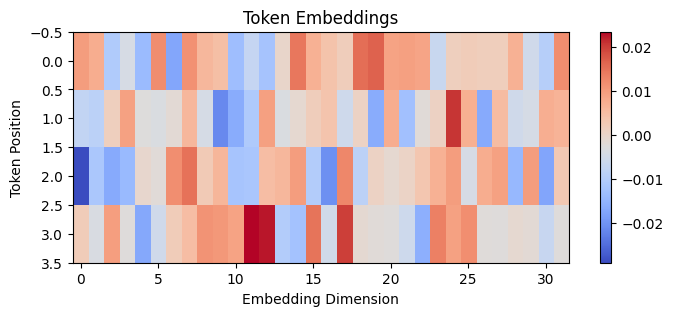

In [61]:
plt.figure(figsize=(8,3))
plt.imshow(X_emb[sample_id], aspect="auto", cmap="coolwarm")
plt.colorbar()
plt.xlabel("Embedding Dimension")
plt.ylabel("Token Position")
plt.title("Token Embeddings")
plt.show()


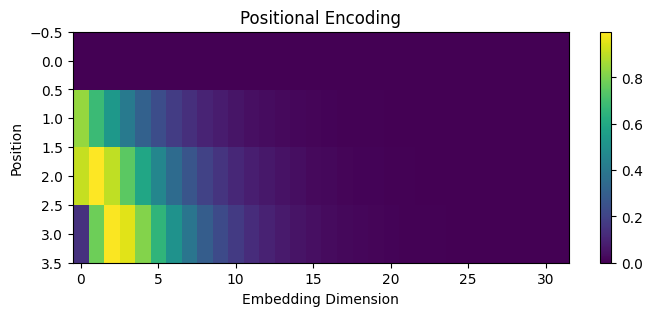

In [62]:
plt.figure(figsize=(8,3))
plt.imshow(PE, aspect="auto", cmap="viridis")
plt.colorbar()
plt.xlabel("Embedding Dimension")
plt.ylabel("Position")
plt.title("Positional Encoding")
plt.show()


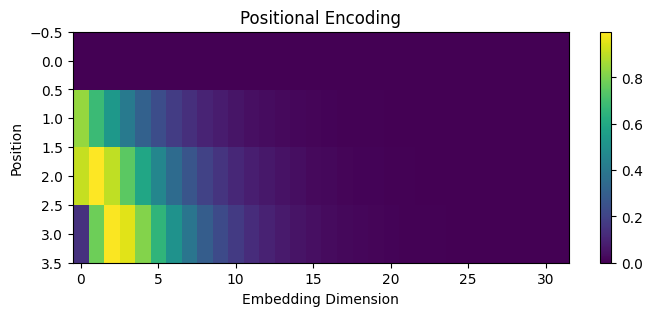

In [63]:
plt.figure(figsize=(8,3))
plt.imshow(PE, aspect="auto", cmap="viridis")
plt.colorbar()
plt.xlabel("Embedding Dimension")
plt.ylabel("Position")
plt.title("Positional Encoding")
plt.show()


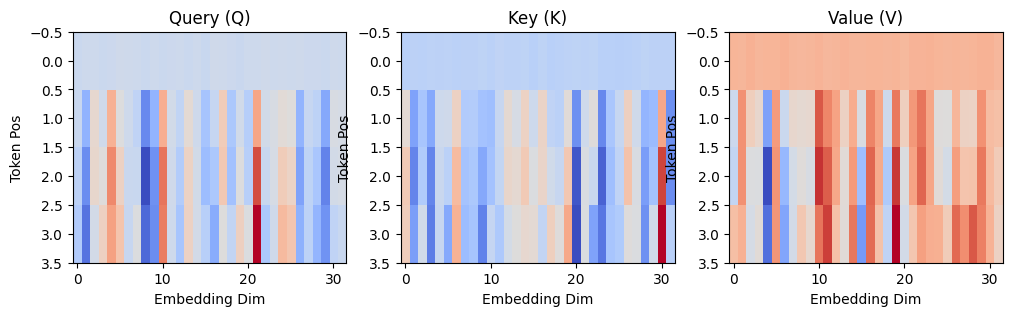

In [64]:
fig, axs = plt.subplots(1,3, figsize=(12,3))

axs[0].imshow(Q[sample_id], aspect="auto", cmap="coolwarm")
axs[0].set_title("Query (Q)")

axs[1].imshow(K[sample_id], aspect="auto", cmap="coolwarm")
axs[1].set_title("Key (K)")

axs[2].imshow(V[sample_id], aspect="auto", cmap="coolwarm")
axs[2].set_title("Value (V)")

for ax in axs:
    ax.set_xlabel("Embedding Dim")
    ax.set_ylabel("Token Pos")

plt.show()


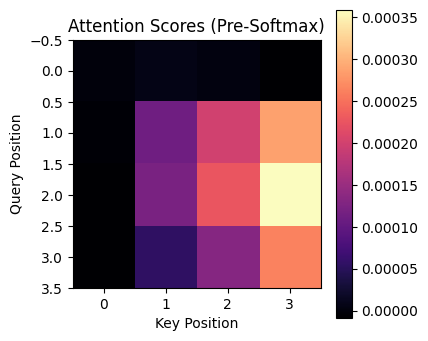

In [65]:
plt.figure(figsize=(4,4))
plt.imshow(scores[sample_id], cmap="magma")
plt.colorbar()
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.title("Attention Scores (Pre-Softmax)")
plt.show()


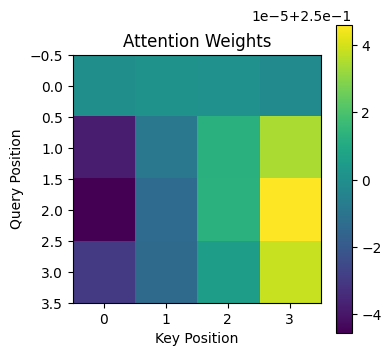

In [66]:
plt.figure(figsize=(4,4))
plt.imshow(attention_weights[sample_id], cmap="viridis")
plt.colorbar()
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.title("Attention Weights")
plt.show()


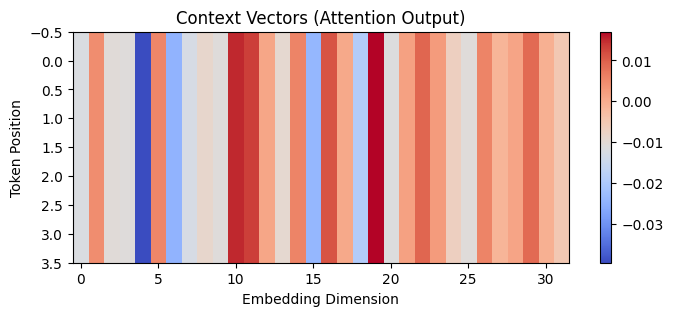

In [67]:
plt.figure(figsize=(8,3))
plt.imshow(Z[sample_id], aspect="auto", cmap="coolwarm")
plt.colorbar()
plt.xlabel("Embedding Dimension")
plt.ylabel("Token Position")
plt.title("Context Vectors (Attention Output)")
plt.show()


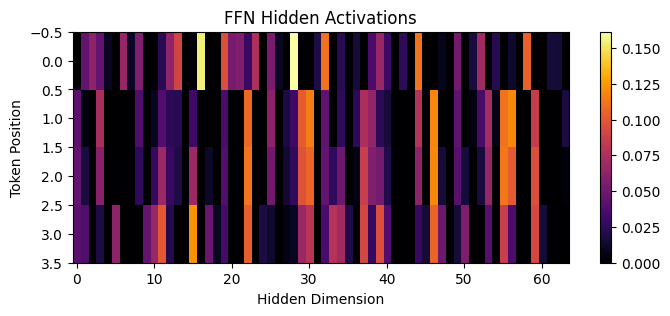

In [68]:
plt.figure(figsize=(8,3))
plt.imshow(FFN_hidden[sample_id], aspect="auto", cmap="inferno")
plt.colorbar()
plt.xlabel("Hidden Dimension")
plt.ylabel("Token Position")
plt.title("FFN Hidden Activations")
plt.show()


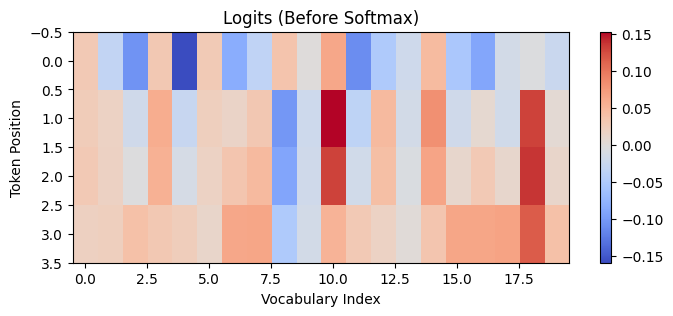

In [69]:
plt.figure(figsize=(8,3))
plt.imshow(logits[sample_id], aspect="auto", cmap="coolwarm")
plt.colorbar()
plt.xlabel("Vocabulary Index")
plt.ylabel("Token Position")
plt.title("Logits (Before Softmax)")
plt.show()


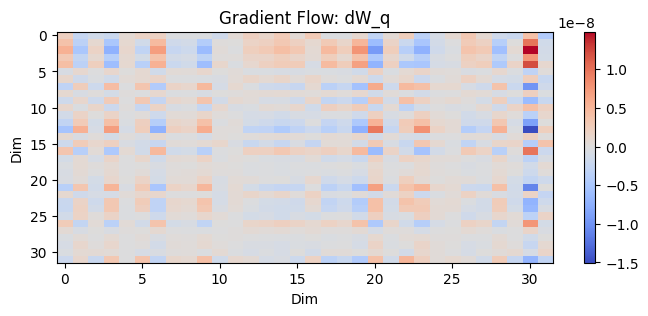

In [71]:
plt.figure(figsize=(8,3))
plt.imshow(dW_q, aspect="auto", cmap="coolwarm")
plt.colorbar()
plt.title("Gradient Flow: dW_q")
plt.xlabel("Dim")
plt.ylabel("Dim")
plt.show()
